# Project 5d-SIR models in SPACE

Until now, we have been approaching disease models in a way that lumps spatial information: entire population classes, despite the fact that humans are geographically separated, are treated as single variables (S,I, or R).  However, it is possible to simulate disease propagation at rather different levels of detail.  One very interesting and very detailed way is to use agent-based models, which means that every single person in the environment is treated individually.  Such models are quite expensive to run.  Another way is a lattice SIR model, which is what we will explore in this section (partially as a means of motivating our next class of model).  

The lattice model is very simple.  Instead of modelling an entire population via a single S, I, and R, we will define an $n\times n$ grid and each location on the grid will have its own SIR status (to be concrete, you could represent these by three numpy arrays).  At each of these locations $k$, we might have dynamics like
$$
\frac{\partial S_{k}}{\partial t} = -\beta S_{k} I_{k}
$$
$$
\frac{\partial I_{k}}{\partial t} = \beta S_{k} I_{k} - \gamma I_{k}
$$
$$
\frac{\partial R_{k}}{\partial t} = \gamma I_{k}.
$$
However, this wouldn't be a very interesting model because each of the locations on the grid are independent from one another.  Instead, we would like adjacent grid cells to be *coupled* (this is similar to the Game of Life).  What sort of coupling makes sense?  There are many possible situations that we could model now that we have some spatial dependency.  One simple possibility states that: rather than susceptible individuals being converted into infected individuals as $-\beta S_{k} I_{k}$, we could have that  
$$
\frac{\partial S_{k}}{\partial t} = -\beta S_{k}\; \sum_{j\in adj(k)} \frac{I_j}{9},
$$
(with a similar modification to the rate of change in infected) which is to say that the infection probability is now proportional to the average number of infected individuals in the cells adjacent to $k$. 

**Implement and run the model described above. Begin by using $n=50$, $\beta=1$, and $\gamma=0.1$.  Assume periodic boundary conditions.  Start with only a single grid cell somewhere in the domain containing an infected individual.**  A few hints for modifying your code: just like with the molecular dynamics problem, you'll need to figure out a way to map from a vector of variables of size $3N$, with $N=n^2$ to the S, I, and R values at each location in a grid.  Internally within my rhs function I (for example) took the first $N$ elements in my vector to be my $S$ values and then explicitly reshaped them back into a grid using np.reshape.  At the end of this function, I turned grid variables back into a vector using np.ravel and concatenation.  For computing the spatial average, I suggest the convolve2d function from scipy.signal (pay attention to the keyword arguments for easy implementation of boundaries, in particular boundary='wrap').

In [1]:
import numpy as np
from scipy.signal import convolve2d
import ode_methods as om
import matplotlib.pyplot as plt

class SpatialSIR:
    def __init__(self, n=50, beta=1, gamma=0.1):
        self.n = n
        self.beta = beta
        self.gamma = gamma
        self.kernel = np.ones((3, 3)) / 9 # used for convolution
        self.n_dof = 3 * n * n
        self.u0 = np.zeros(self.n_dof)
        self.u0[:n*n] = 1  # All cells are susceptible
        self.u0[n*n + n//2*n + n//2] = 1  # One cell is infected

    def rhs(self, t, u):
        S = u[:self.n*self.n].reshape((self.n, self.n))
        I = u[self.n*self.n:2*self.n*self.n].reshape((self.n, self.n))
        R = u[2*self.n*self.n:].reshape((self.n, self.n))

        dSdt = -self.beta * S * convolve2d(I, self.kernel, mode='same', boundary='wrap')
        dIdt = self.beta * S * convolve2d(I, self.kernel, mode='same', boundary='wrap') - self.gamma * I
        dRdt = self.gamma * I

        return np.concatenate((dSdt.ravel(), dIdt.ravel(), dRdt.ravel()))

    def run(self, method, t_span, dt):
        integrator = om.Integrator(self, method)
        t, u = integrator.integrate(t_span, dt, self.u0)
        return t, u

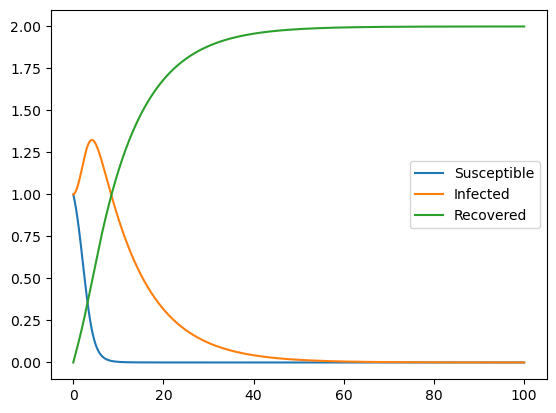

In [2]:
method = om.Heun()
s = SpatialSIR()
t, u = s.run(method, [0, 100], 0.01)

# Plotting the results
# Note: The results are now 3D arrays, so you need to reshape them back to 2D to plot them
S = u[:, :s.n*s.n].reshape((-1, s.n, s.n))
I = u[:, s.n*s.n:2*s.n*s.n].reshape((-1, s.n, s.n))
R = u[:, 2*s.n*s.n:].reshape((-1, s.n, s.n))

# Plot the number of susceptible, infected, and recovered individuals in the center cell over time
plt.plot(t, S[:, s.n//2, s.n//2], label='Susceptible')
plt.plot(t, I[:, s.n//2, s.n//2], label='Infected')
plt.plot(t, R[:, s.n//2, s.n//2], label='Recovered')
plt.legend()

**Animate the solution (I suggest repurposing code from Conway's Game of Life).  Describe the patterns that you see of the population classes in space and time.** 

In [ ]:
import pygame
import time

# Initialize Pygame
pygame.init()

# Create a window
cell_size = 10  # Size of each cell in pixels
window = pygame.display.set_mode((s.n * cell_size, s.n * cell_size))

# Define colors
colors = {
    'S': (0, 255, 0),   # Green
    'I': (255, 0, 0),   # Red
    'R': (0, 0, 255),   # Blue
}

# Function to draw the grid
def draw_grid(u):
    for i in range(s.n):
        for j in range(s.n):
            # Determine the state of the cell
            if u[i, j, 0] > u[i, j, 1] and u[i, j, 0] > u[i, j, 2]:
                state = 'S'
            elif u[i, j, 1] > u[i, j, 0] and u[i, j, 1] > u[i, j, 2]:
                state = 'I'
            else:
                state = 'R'
            # Draw the cell
            rect = pygame.Rect(i * cell_size, j * cell_size, cell_size, cell_size)
            pygame.draw.rect(window, colors[state], rect)

# Main loop
for t_index in range(len(t)):
    # Clear the window
    window.fill((255, 255, 255))

    # Draw the grid
    draw_grid(u[t_index].reshape((s.n, s.n, 3)))

    # Update the window
    pygame.display.flip()

    # Wait for a short delay
    time.sleep(0.01)

# Quit Pygame
pygame.quit()

### Barriers
We can utilize this model to explore the influence of geographic barriers to disease propagation.  First, modify your code to accept a spatially varying value of $\beta$, i.e. 
$$
\frac{\partial S_{k}}{\partial t} = -\beta_k S_{k}\; \sum_{j\in adj(k)} \frac{I_j}{9}.
$$
Second, modify your boundary conditions to *not* be periodic.  If you used scipy.convolve, then you can do this by changing the boundary keyword to 'symm'.    

**Now, create a simulation that utilizes a barrier.  For example, you might set the middle 1/3 of the domain to have $\beta=0$.  How does the simulation change?  If the barrier is imperfect, does the disease still reach the other side?**